## Step 1: Testing YOLO v11 of detecting and tracking pedestrain

In [1]:
from IPython.display import display, clear_output
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from ultralytics import YOLO
import os

In [2]:
# Load the local YOLOv11 model 
model = YOLO("yolo11m.pt")

/opt/anaconda3/envs/huggingface/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
def detect_track(video_dir, output_dir):
    # make sure the output_dir exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Video file path (replace with your own)
    cap = cv2.VideoCapture(video_dir)
    
    # Get original video info
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # VideoWriter will be initialized after first annotated frame (to match exact resolution)
    save_output = True
    out = None
    video_name = os.path.splitext(os.path.basename(video_dir))[0]
    output_path = os.path.join(output_dir, f"{video_name}_output.mp4")
    
    # Prepare list for detection results
    all_detections = []
    frame_index = 0
    
    # Start reading video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
    
        # Perform tracking (ByteTrack), detecting only person class (class 0)
        results = model.track(frame, persist=True, classes=[0], tracker="bytetrack.yaml")
        annotated = results[0].plot()  # Annotated frame for visualization
    
        # Initialize VideoWriter if needed (after first annotated frame)
        if save_output and out is None:
            ann_height, ann_width = annotated.shape[:2]
            out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (ann_width, ann_height))
    
        # Extract bounding boxes and IDs (if any)
        bboxes = results[0].boxes.xyxy.cpu().numpy()
        ids = results[0].boxes.id
        if ids is not None:
            ids = ids.int().tolist()
        else:
            ids = [-1] * len(bboxes)  # -1 means untracked
    
        # Record detection results to list
        for obj_id, bbox in zip(ids, bboxes):
            x1, y1, x2, y2 = bbox
            all_detections.append({
                "frame": frame_index,
                "id": int(obj_id),
                "x1": float(x1),
                "y1": float(y1),
                "x2": float(x2),
                "y2": float(y2)
            })
    
        # Display current frame in Jupyter
        img_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
        clear_output(wait=True)
        display(Image.fromarray(img_rgb))
    
        # Save current frame to output video
        if save_output:
            out.write(annotated)
    
        frame_index += 1
    
    # Release video and save results
    cap.release()
    if out is not None:
        out.release()
    cv2.destroyAllWindows()
    
    # Save detection results to CSV
    df = pd.DataFrame(all_detections)
    df.to_csv(os.path.join(output_dir, f"{video_name}_results.csv"), index=False)

    print("Tracking complete. Outputs saved")

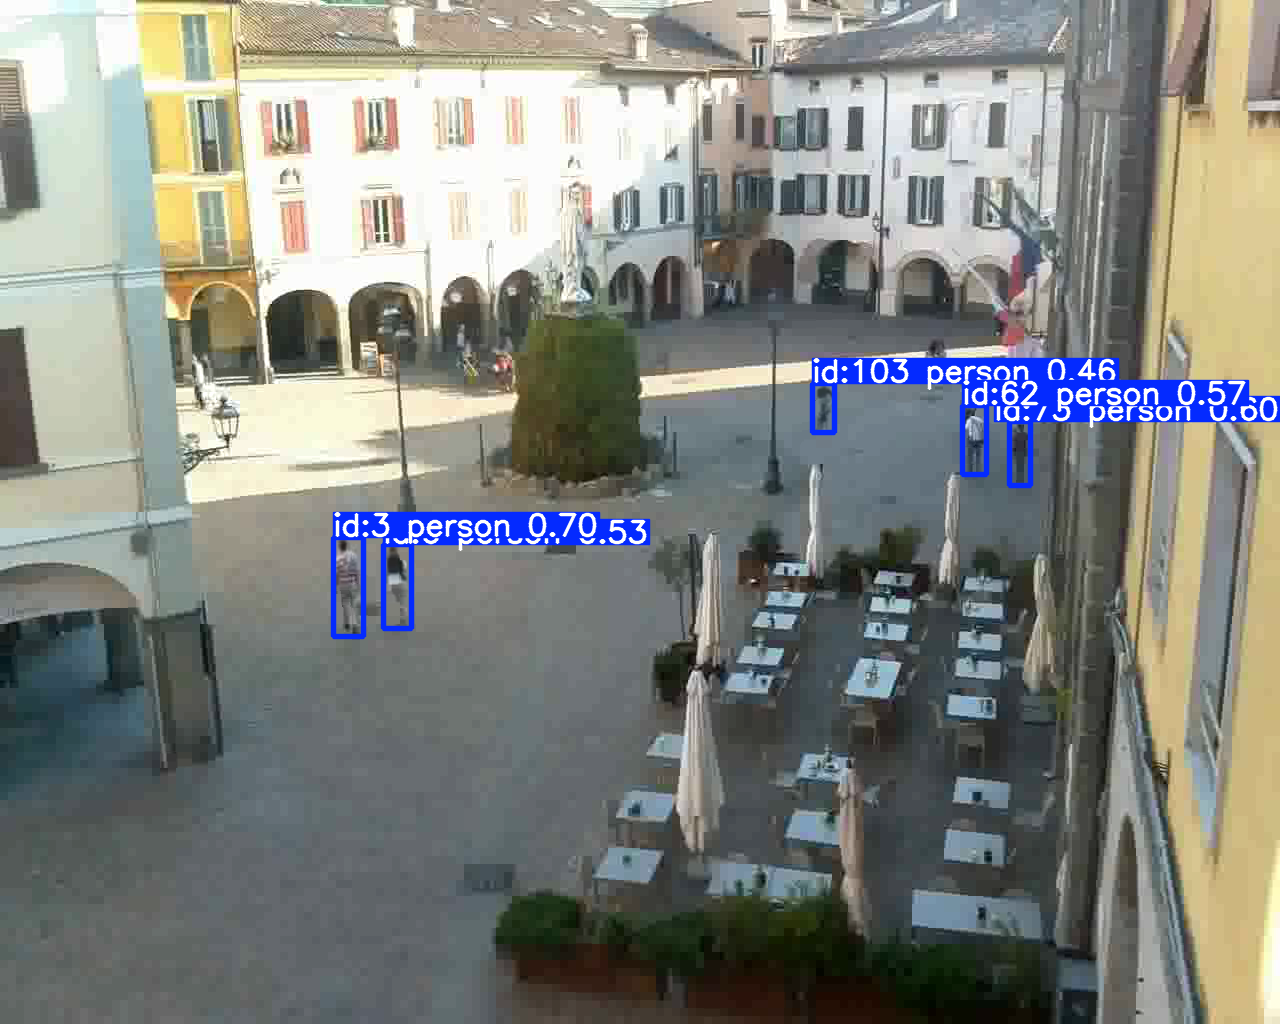

Tracking complete. Outputs saved


In [4]:
video_dir = "video/nuclear_test_15.mp4"
output_dir = "output"
detect_track(video_dir, output_dir)

In [5]:
# CSV Output Explanation:
# The CSV file 'yolo_track_results.csv' contains one row per detected object per frame.
# Each row includes the following columns:
#
# - frame:        The index of the video frame where the detection occurred (0-based).
# - id:           The tracking ID assigned by ByteTrack.
#                 Objects with the same ID across frames are considered the same tracked person.
#                 An ID of -1 indicates that no stable tracking ID was assigned (e.g., early frames or low confidence).
# - x1, y1:       The coordinates of the top-left corner of the bounding box (in pixels).
# - x2, y2:       The coordinates of the bottom-right corner of the bounding box (in pixels).
#
# These coordinates are relative to the resolution of the original input frame.

df_test = pd.read_csv("output/nuclear_test_15_results.csv")
df_test

frame   id           x1          y1           x2           y2
0         0    1    86.935654  769.614319   132.187576   884.825500
1         0    2    51.777321  769.004272    91.232918   893.318726
2         0    3   352.970581  979.043640   402.730591  1023.480286
3         0    4   615.638855  534.641785   638.167664   609.842102
4         0    5   687.771790  353.340729   710.674377   411.254913
...     ...  ...          ...         ...          ...          ...
1495    224    3   333.170502  537.861389   363.679657   636.641541
1496    224   62   962.238708  405.511932   986.328308   474.298676
1497    224    6   383.211975  544.037048   411.395325   628.114502
1498    224   73  1009.487793  421.310425  1030.828003   485.283630
1499    224  103   812.981079  383.609039   834.230896   432.228333

[1500 rows x 6 columns]

## Step 2: Read a webcam video and clip

In [6]:
from moviepy import VideoFileClip

In [7]:
# clip the original video to save computating time
clip = VideoFileClip('video/Live Cam Iseo _ SkylineWebcams _(9_30_16_55).mp4').subclipped(0, 300)
clip.write_videofile('video/cam_iseo.mp4', fps = 1, codec='mpeg4', audio = False)

MoviePy - Building video video/cam_iseo.mp4.
MoviePy - Writing video video/cam_iseo.mp4



MoviePy - Done !
MoviePy - video ready video/cam_iseo.mp4


## Step 3: Run YOLO to detect and track pedestrian in the clip and save the results

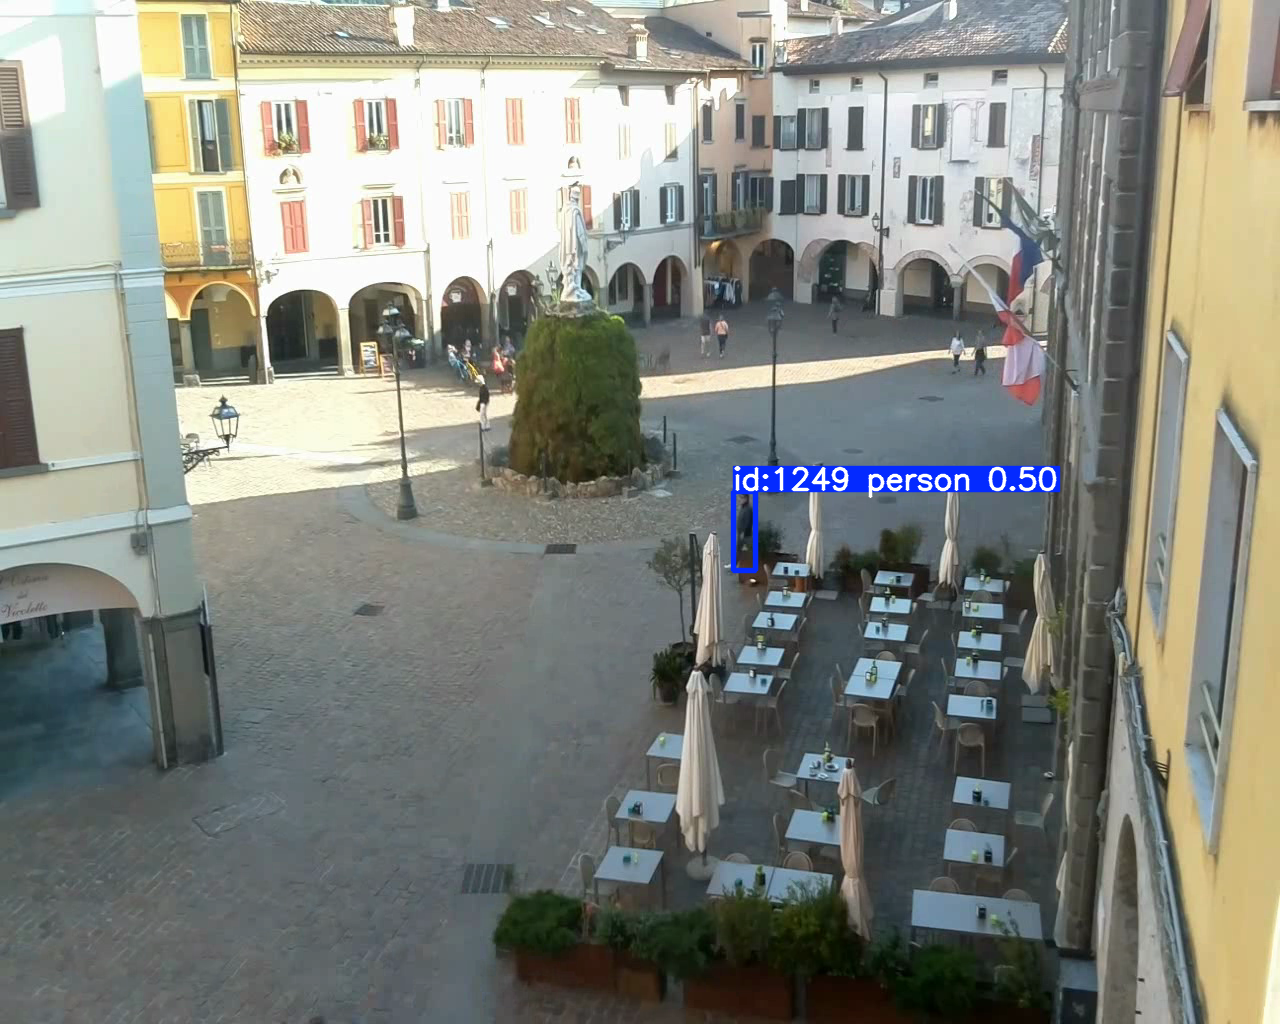

Tracking complete. Outputs saved


In [8]:
video_dir = "video/cam_iseo.mp4"
output_dir = "output"
detect_track(video_dir, output_dir)

## Step 4: Visualize pedestrian footprint heatmap and trajectories

In [64]:
# Load CSV
df = pd.read_csv('output/cam_iseo_results.csv')

# Calculate bottom center point of each bounding box
df['x_center'] = (df['x1'] + df['x2']) / 2
df['y_bottom'] = df['y2']  # Use bottom edge for vertical coordinate

In [66]:
# save a frame from the video as background
video_path = "video/cam_iseo.mp4"
frame_number = 100  # any frame
background_img_path = "output/bg_frame.jpg"

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()
cap.release()

if ret:
    cv2.imwrite(background_img_path, frame)

In [69]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns

# Load CSV and calculate bottom center point
df = pd.read_csv('output/cam_iseo_results.csv')
df['x_center'] = (df['x1'] + df['x2']) / 2
df['y_bottom'] = df['y2']

# Load background image
bg_img = mpimg.imread("output/viz/bg_frame.jpg")
height, width = bg_img.shape[:2]

/opt/anaconda3/envs/huggingface/lib/python3.13/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


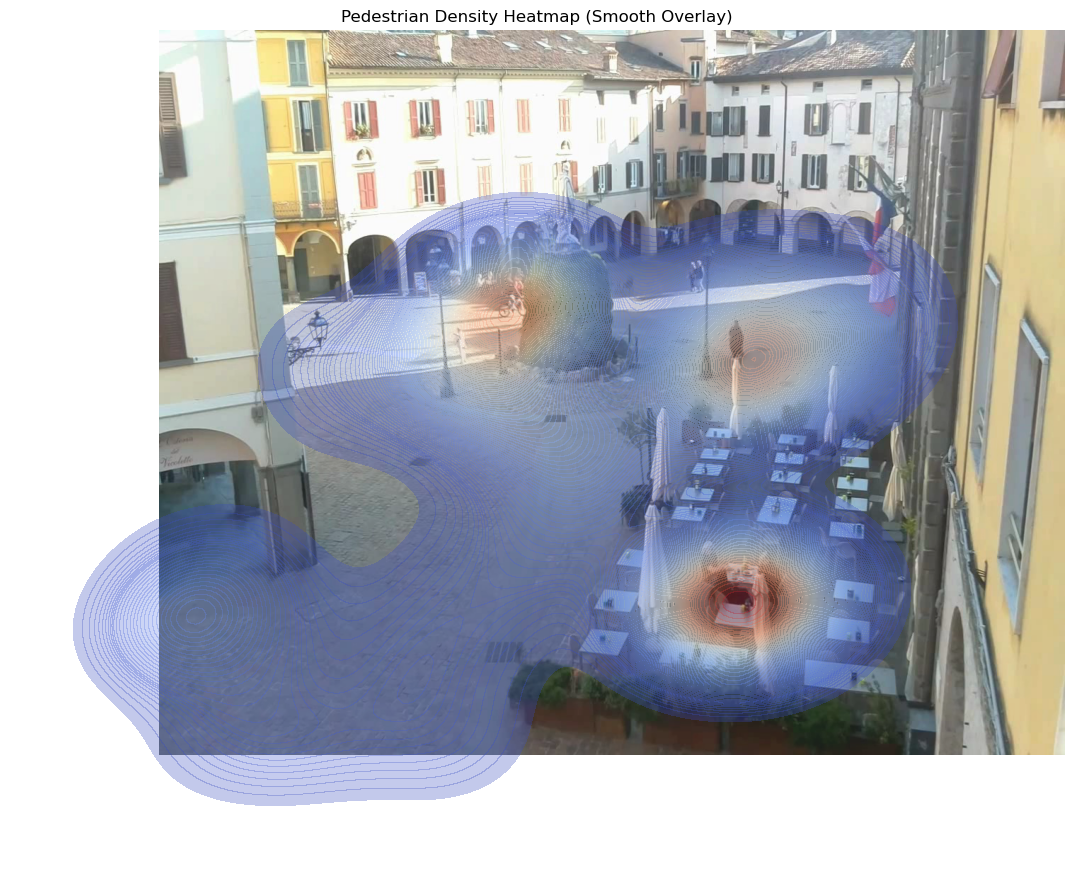

In [87]:
# Visualize pedestrian footprint heatmap

plt.figure(figsize=(12, 9))

# Show background image with transparency
plt.imshow(bg_img, extent=[0, width, height, 0], alpha=0.9)

# KDE heatmap with smooth blending and no white contour lines
sns.kdeplot(
    x=df['x_center'],
    y=df['y_bottom'],
    fill=True,              # fill area under KDE
    cmap="coolwarm",            # smooth color map
    bw_adjust=1.0,          # bandwidth
    levels=100,             # more levels = smoother gradient
    alpha=0.3,              # transparency of the heatmap
    thresh=0.02,            # remove low-density noise
    linewidths=0            # no contour lines (white borders)
)

plt.title("Pedestrian Density Heatmap (Smooth Overlay)")
plt.axis('off')
plt.tight_layout()
plt.savefig("output/viz/heatmap_overlay.png", dpi=300)
plt.show()

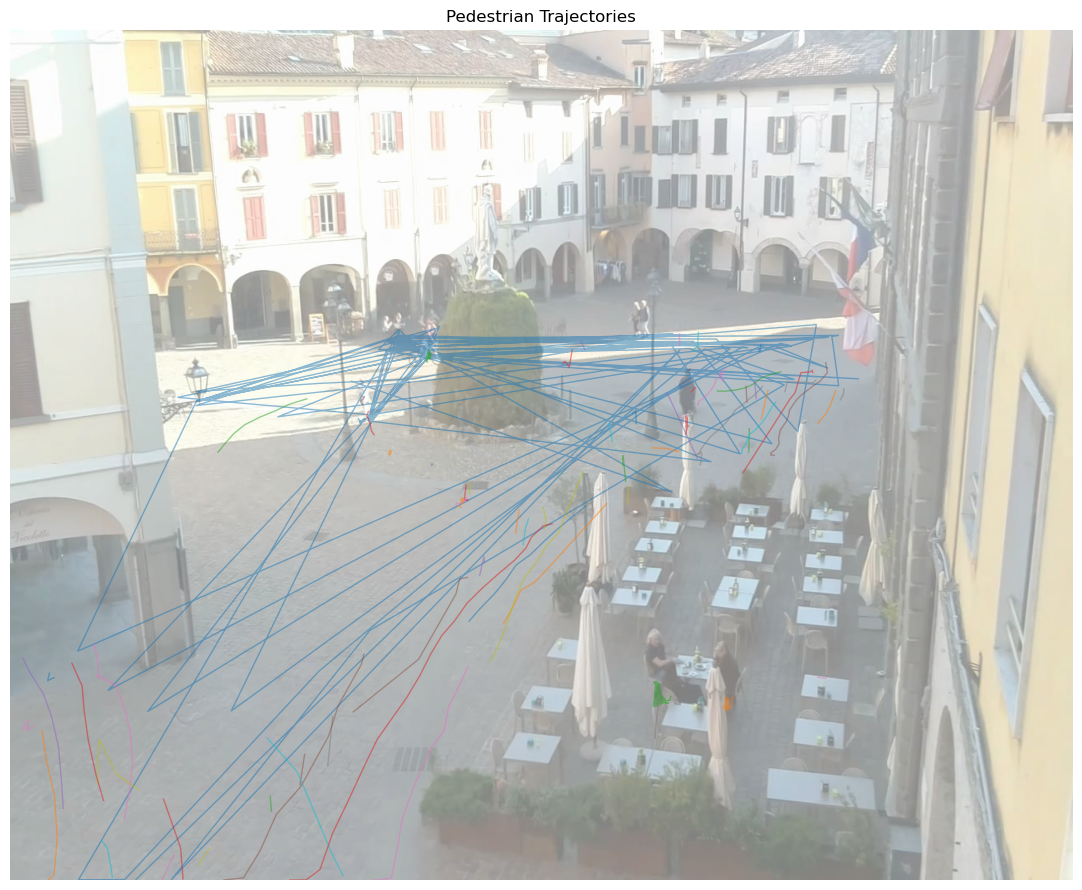

In [88]:
# Pedestrian Trajectories
plt.figure(figsize=(12, 9))

# Show background image
plt.imshow(bg_img, extent=[0, width, height, 0], alpha=0.5)

# Draw each trajectory
for pid, group in df.groupby("id"):
    plt.plot(group['x_center'], group['y_bottom'], linewidth=1, alpha=0.5)

plt.title("Pedestrian Trajectories")
plt.axis('off')
plt.tight_layout()
plt.savefig("output/viz/trajectory_overlay.png", dpi=300)
plt.show()

## Step 5: Generate a visualizing clip

In [1]:
# import visualize function from prepared scripts
from visualize_trajectories import visualize_video

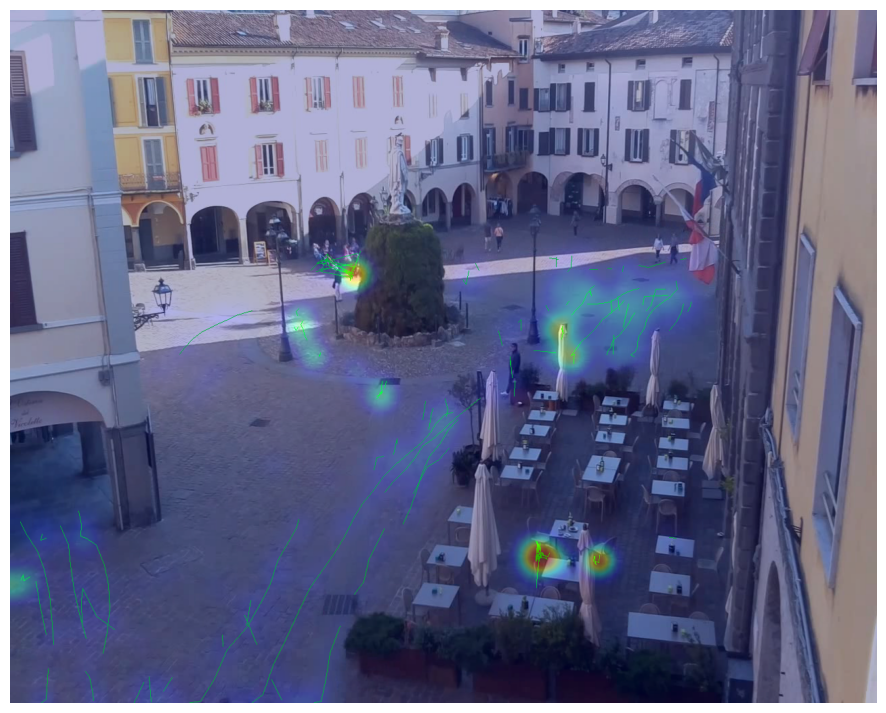

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

In [2]:
visualize_video(
    input_csv='output/cam_iseo_results.csv',
    input_video='video/cam_iseo.mp4',
    output_video='output/viz/cam_iseo_viz.mp4',
    show_window=True
)